In [1]:
import numpy as np
import mccd.auxiliary_fun as mccd_aux
import mccd
from astropy.io import fits

import random

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

%pylab inline

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Populating the interactive namespace from numpy and matplotlib


/Users/oa265351/opt/miniconda3/envs/denoising/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
# test_path = '/Users/tliaudat/Documents/PhD/codes/venv_p3/JB-data/CFIS-data/all_w3_star_cat/star_selection-2079613-7.fits'

#test_cat_path = './../data/mccd_inputs/test_star_selection-2086592.fits'

#test_fits = fits.open(test_cat_path)[1]

#val_dict = mccd_aux.mccd_validation(fitted_model_path, test_cat)

#val_dict.keys()

# test_fits[1].data['Field Header Card']



In [3]:
def plot_imgs(mat, cmap = 'gist_stern', figsize=(20,20)):

    def dp(n, left): # returns tuple (cost, [factors])
        memo = {}   
        if (n, left) in memo: return memo[(n, left)]

        if left == 1:
            return (n, [n])

        i = 2
        best = n
        bestTuple = [n]
        while i * i <= n:
            if n % i == 0:
                rem = dp(n / i, left - 1)
                if rem[0] + i < best:
                    best = rem[0] + i
                    bestTuple = [i] + rem[1]
            i += 1

        memo[(n, left)] = (best, bestTuple)
        return memo[(n, left)]


    n_images = mat.shape[0]
    row_col = dp(n_images, 2)[1]
    row_n = int(row_col[0])
    col_n = int(row_col[1])

    figure(figsize=figsize)
    idx = 0

    for _i in range(row_n):
        for _j in range(col_n):

            plt.subplot(row_n,col_n,idx+1)
            plt.imshow(mat[idx,:,:], cmap=cmap);colorbar()
            plt.title('matrix id %d'%idx)

            idx += 1

    plt.show()

In [4]:

#base_dir = '/Users/tliaudat/Documents/PhD/MCCD_application/CFIS_app/tests/'

path_fitted_model = './../data/mccd_inputs/fitted_classic.npy'
path_val_data = './../data/mccd_inputs/test_star_selection-21111111.fits'

# path_fitted_model = base_dir + 'test_n06/test_files/' + 'fitted_model-2099932.npy'
# path_val_data = base_dir + 'test_n06/test_files/' + 'validation_psf-2099932.fits'



In [5]:
fitted_model = np.load(path_fitted_model, allow_pickle=True)



In [6]:
fitted_model[0]

{'n_comp_loc': 10, 'd_comp_glob': 6, 'upfact': 1}

In [7]:
print(fitted_model[0].keys())
print(fitted_model[1].keys())


dict_keys(['n_comp_loc', 'd_comp_glob', 'upfact'])
dict_keys(['n_ccd', 'obs_pos', 'A_loc', 'A_glob', 'S', 'flux_ref', 'psf_size', 'VT', 'Pi', 'alpha', 'ccd_list'])


In [8]:
val_data = fits.open(path_val_data)[1]
val_data = mccd_aux.mccd_validation(path_fitted_model, val_data)


In [9]:
val_data.keys()

dict_keys(['PSF_VIGNET_LIST', 'PSF_MOM_LIST', 'STAR_MOM_LIST', 'GLOB_POSITION_IMG_LIST', 'VIGNET_LIST', 'MASK_LIST', 'CCD_ID_LIST'])

In [10]:
A_loc = fitted_model[1]['A_loc']
A_glob = fitted_model[1]['A_glob']

S = fitted_model[1]['S']


In [11]:
S[-1].shape

(51, 51, 28)

In [12]:
val_data['CCD_ID_LIST'][87]

1

In [13]:
len(val_data['PSF_VIGNET_LIST'])

2000

# Check some PSF recosntructions

In [14]:
recon_stars = val_data['PSF_VIGNET_LIST'][0:50,:,:]
obs_stars = val_data['VIGNET_LIST'][0:50,:,:]



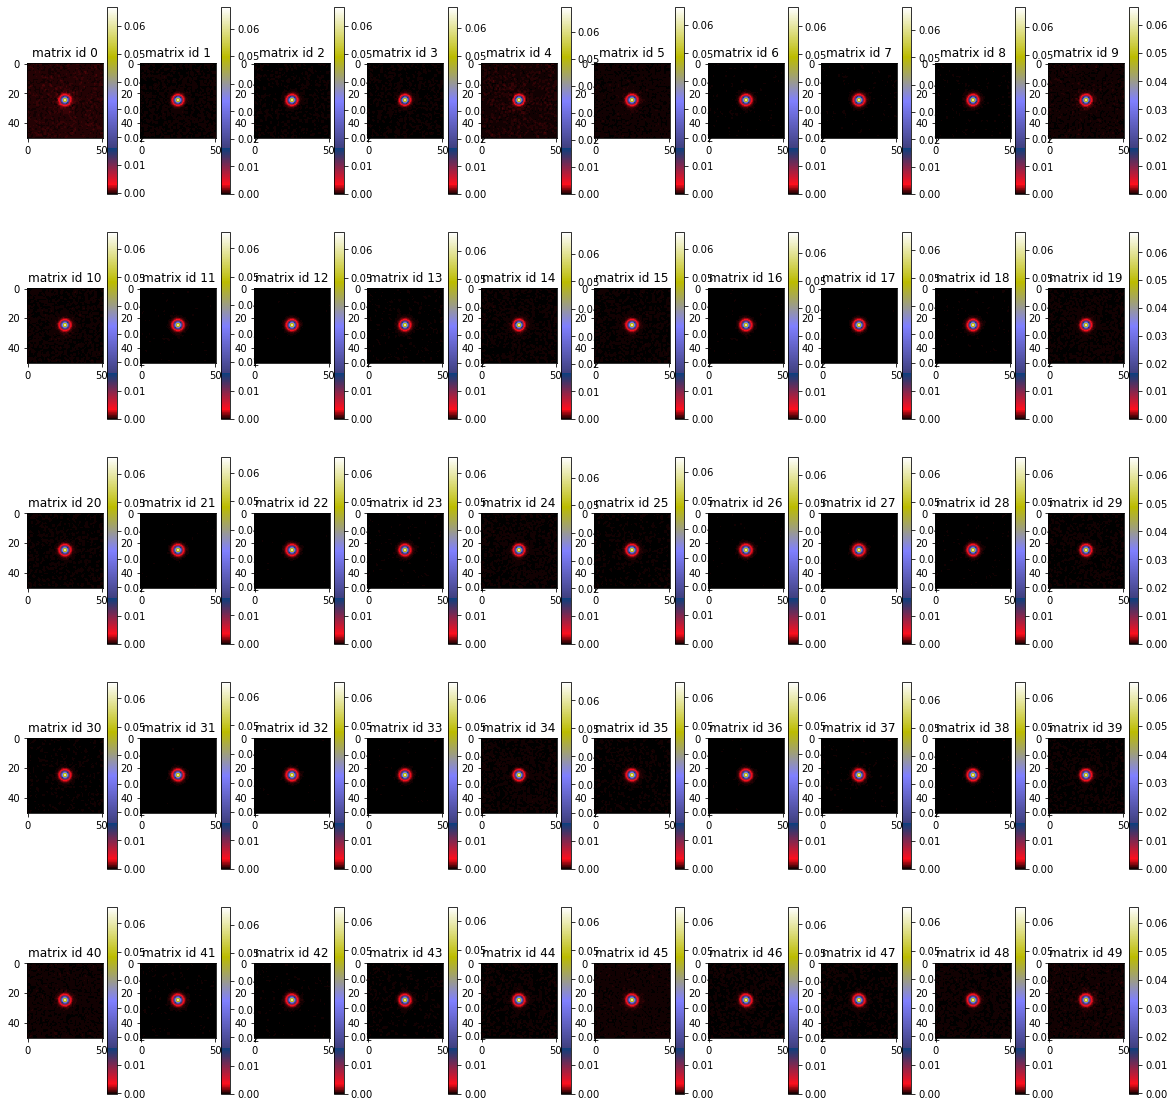

In [15]:
plot_imgs(recon_stars, cmap = 'gist_stern', figsize=(20,20))



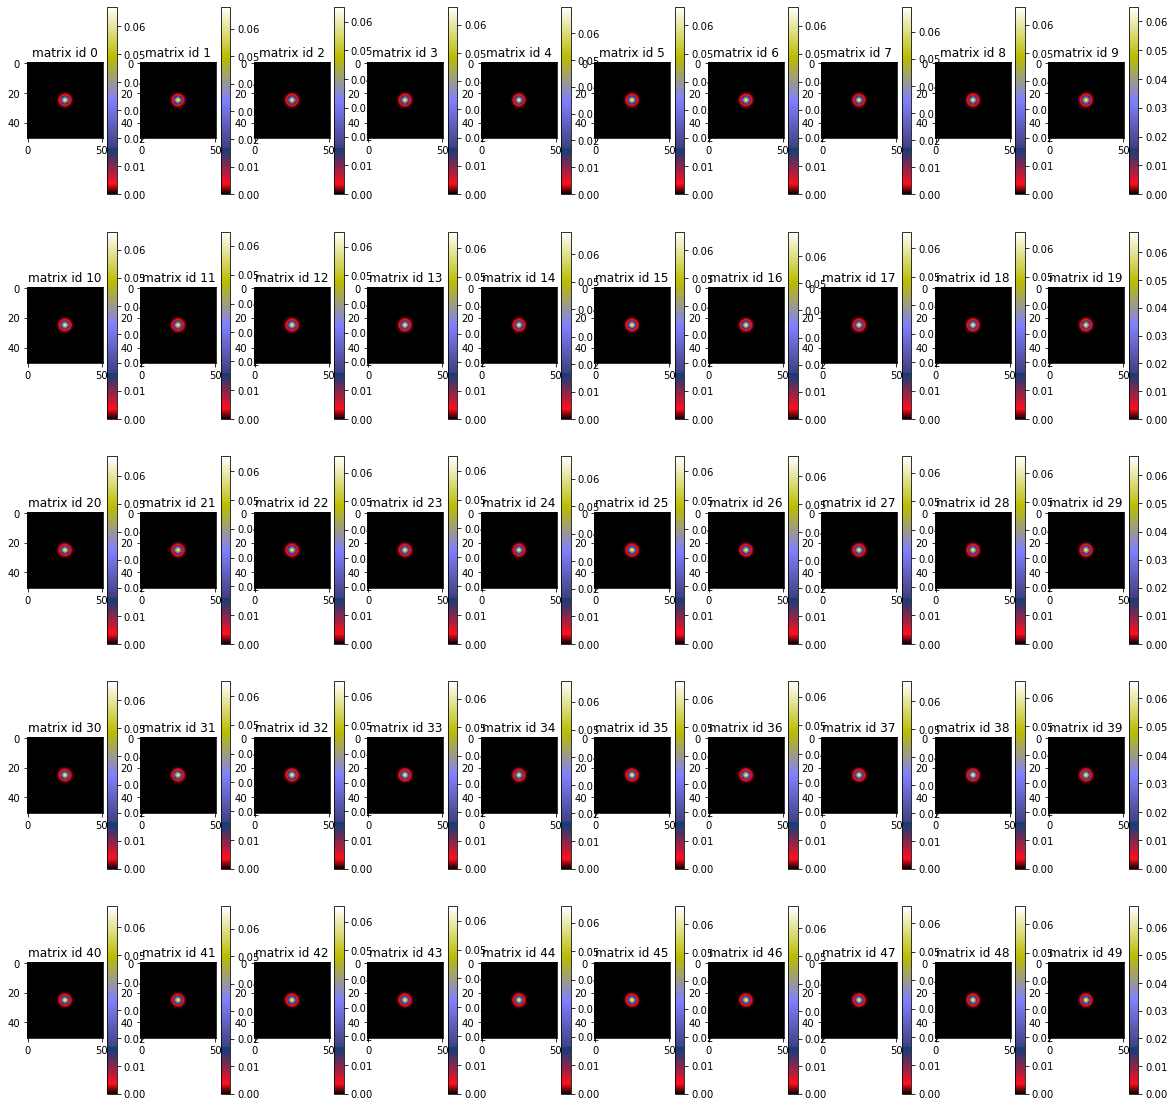

In [16]:

plot_imgs(obs_stars, cmap = 'gist_stern', figsize=(20,20))



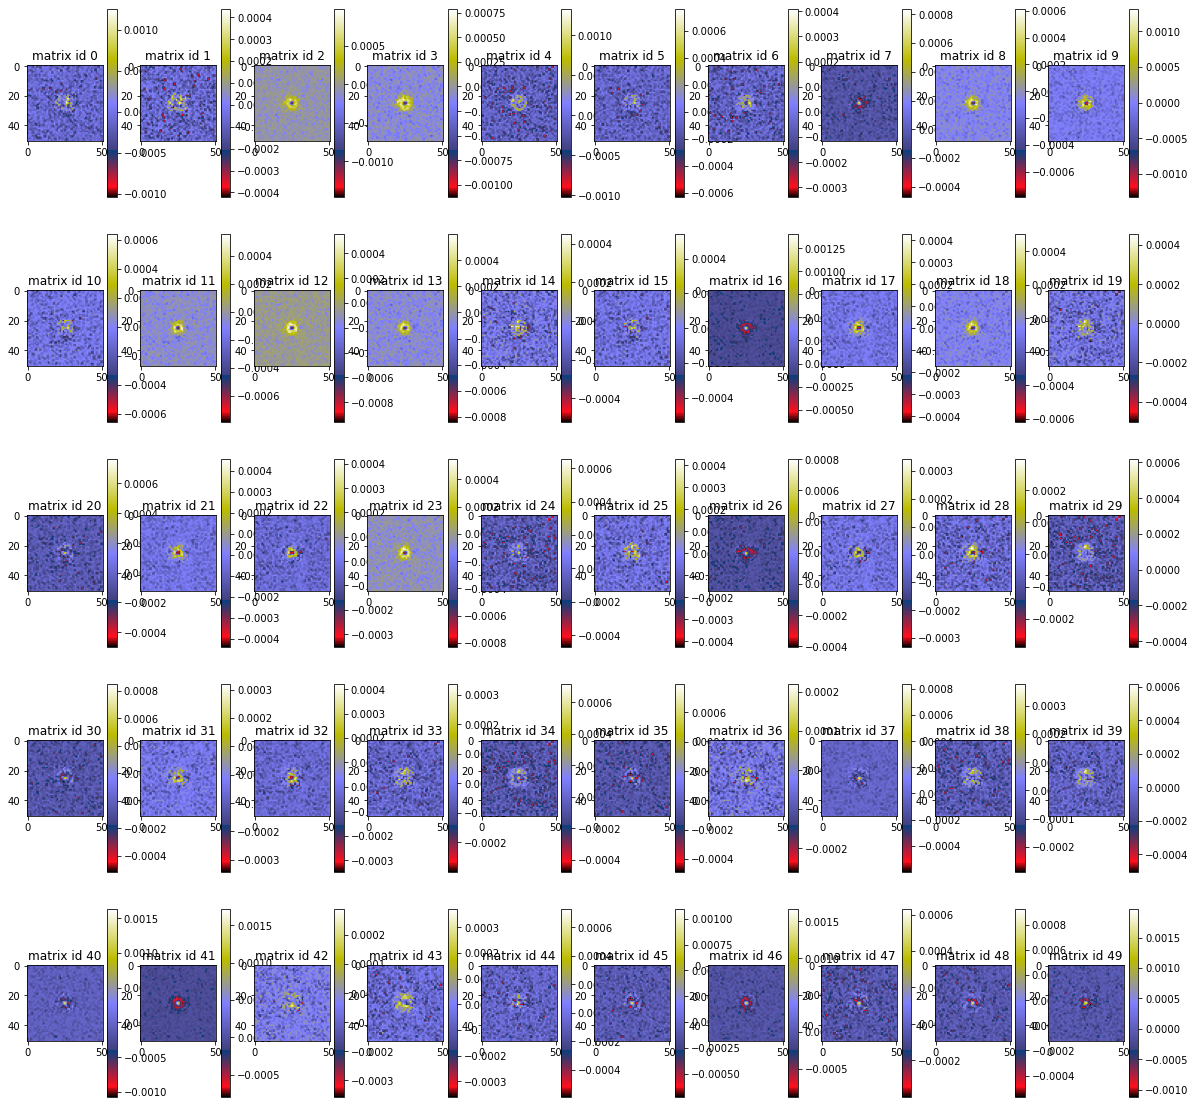

In [17]:
plot_imgs(obs_stars  - recon_stars, cmap = 'gist_stern', figsize=(20,20))



In [18]:

print('pixel RMSE = %.5e'%(np.sqrt(np.mean((obs_stars  - recon_stars)**2 ))))


pixel RMSE = 1.27187e-04


# Global features

In [19]:
S_glob = S[-1]

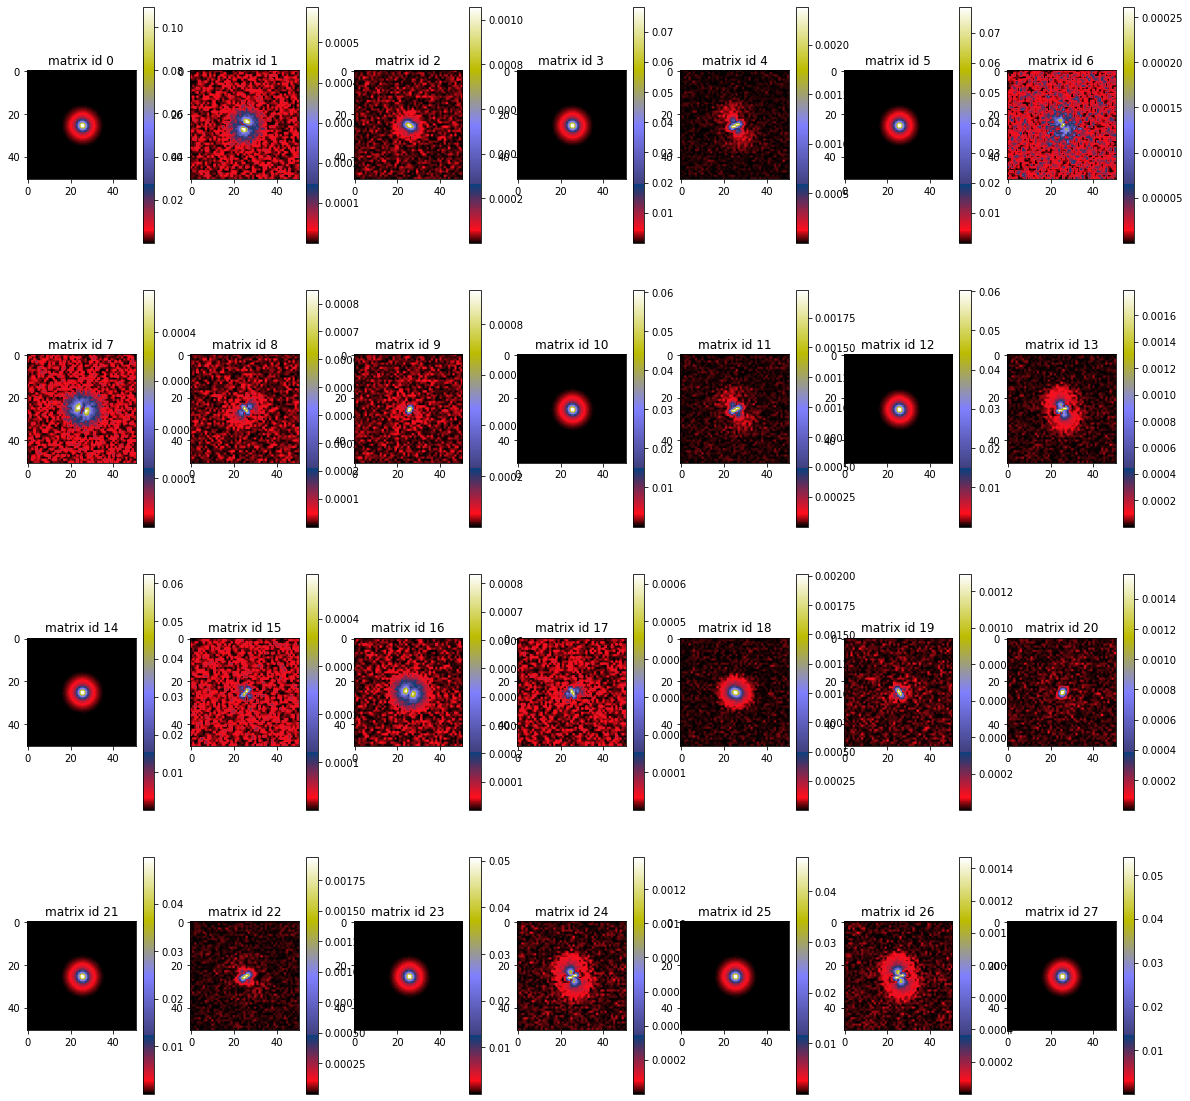

In [20]:

if S_glob.shape[2]>60:
    plot_imgs(mccd.utils.reg_format(abs(S_glob[:,:,:60])), cmap = 'gist_stern', figsize=(20,20))
    plot_imgs(mccd.utils.reg_format(abs(S_glob[:,:,60:])), cmap = 'gist_stern', figsize=(20,20))
else:
    plot_imgs(mccd.utils.reg_format(abs(S_glob)), cmap = 'gist_stern', figsize=(20,20))
    
    

# Local features

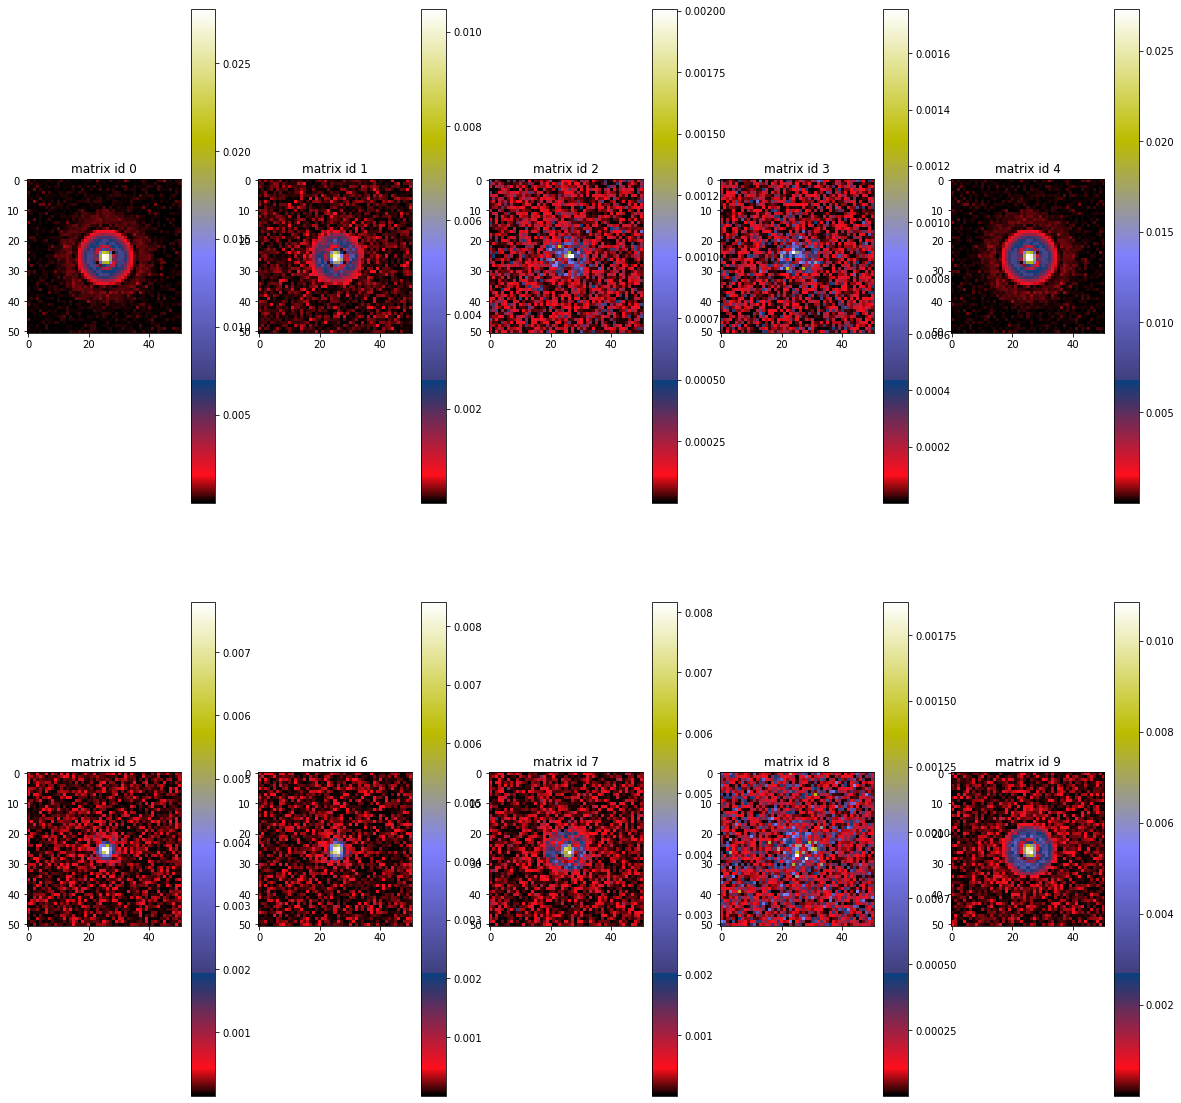

In [21]:
ccd_n = 15

S_loc = S[ccd_n]

plot_imgs(mccd.utils.reg_format(abs(S_loc)), cmap = 'gist_stern', figsize=(20,20))

# Check out measured validation moments

In [22]:
psf_moms = val_data['PSF_MOM_LIST']
star_moms = val_data['STAR_MOM_LIST']


Mean residual e1 = -2.85893e-05
RMSE residual e1 = 1.38553e-03


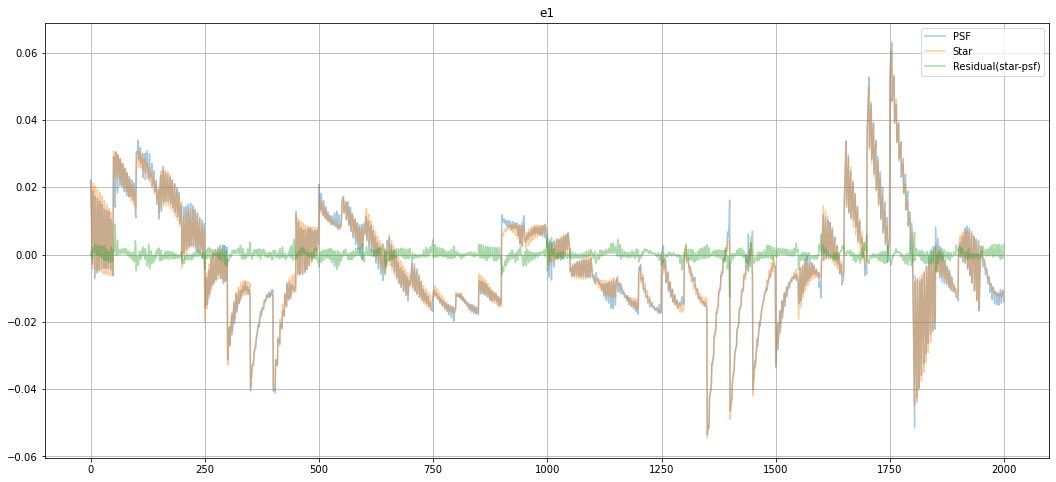

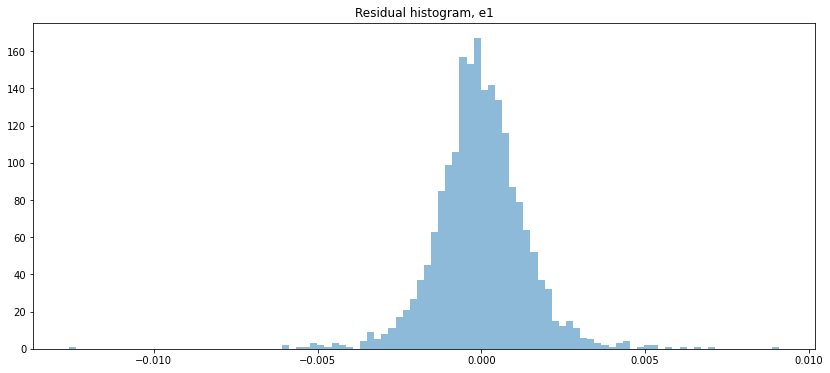

In [23]:
mom_id  = 0

print('Mean residual e1 = %.5e'%(np.mean(star_moms[:,mom_id]-psf_moms[:,mom_id])))
print('RMSE residual e1 = %.5e'%(np.sqrt(np.mean((star_moms[:,mom_id]-psf_moms[:,mom_id])**2 ))))


figure(figsize=(18,8))
plot(psf_moms[:,mom_id], alpha=0.4, label='PSF')
plot(star_moms[:,mom_id], alpha=0.4, label='Star')
plot(star_moms[:,mom_id]-psf_moms[:,mom_id], alpha=0.4, label='Residual(star-psf)')
legend()
grid('minor')
title('e1')
show()


figure(figsize=(14,6))
hist(star_moms[:,mom_id]-psf_moms[:,mom_id], bins=100, alpha=0.5)
title('Residual histogram, e1')
show()



Mean residual e2 = 5.93371e-05
RMSE residual e2 = 1.70788e-03


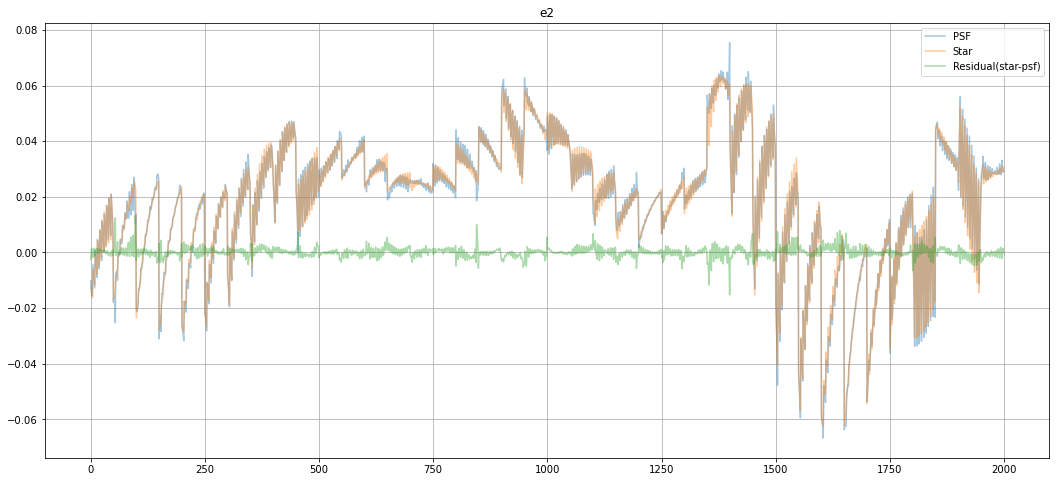

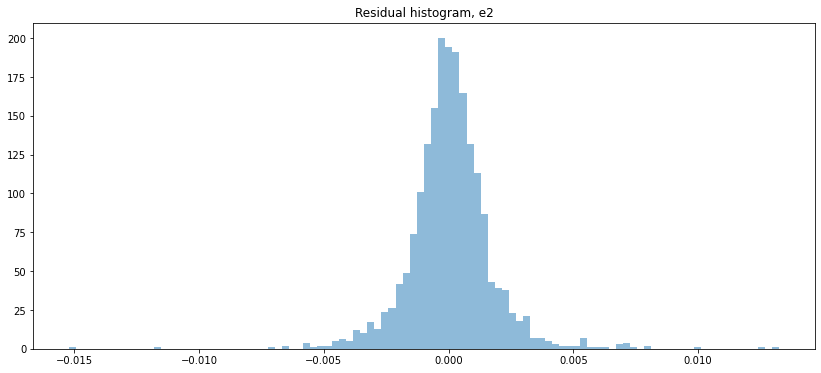

In [24]:
mom_id  = 1

print('Mean residual e2 = %.5e'%(np.mean(star_moms[:,mom_id]-psf_moms[:,mom_id])))
print('RMSE residual e2 = %.5e'%(np.sqrt(np.mean((star_moms[:,mom_id]-psf_moms[:,mom_id])**2 ))))



figure(figsize=(18,8))
plot(psf_moms[:,mom_id], alpha=0.4, label='PSF')
plot(star_moms[:,mom_id], alpha=0.4, label='Star')
plot(star_moms[:,mom_id]-psf_moms[:,mom_id], alpha=0.4, label='Residual(star-psf)')
legend()
grid('minor')
title('e2')
show()


figure(figsize=(14,6))
hist(star_moms[:,mom_id]-psf_moms[:,mom_id], bins=100, alpha=0.5)
title('Residual histogram, e2')
show()

Mean residual sigma = -9.27020e-04
RMSE residual R2 / R2 = 1.53753e-02


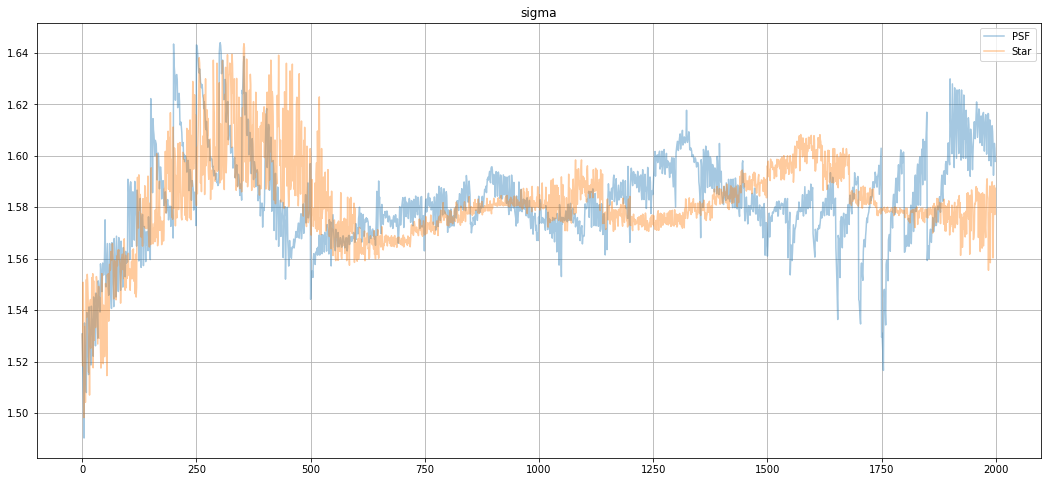

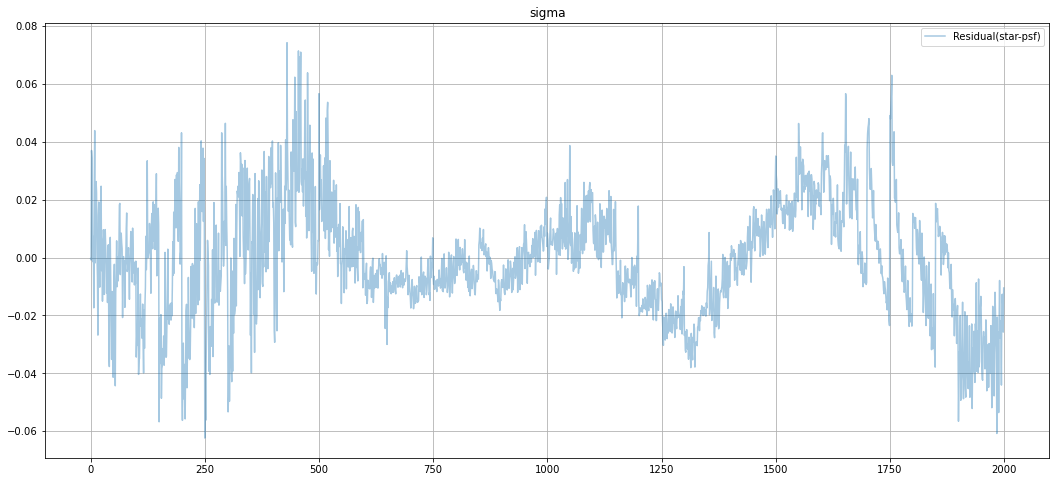

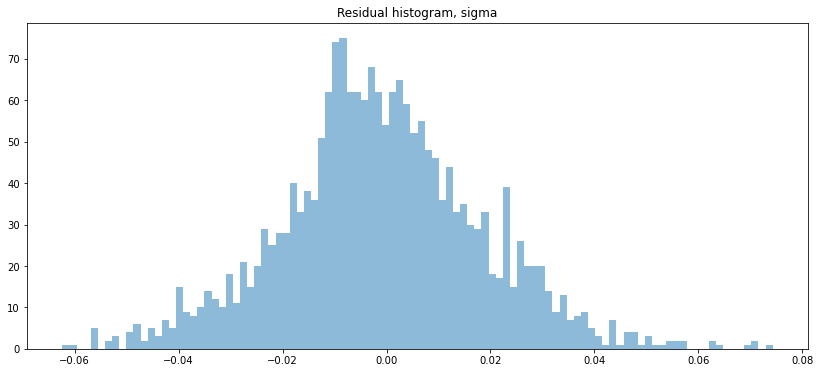

In [25]:
mom_id  = 2

print('Mean residual sigma = %.5e'%(np.mean(star_moms[:,mom_id]-psf_moms[:,mom_id])))
print('RMSE residual R2 / R2 = %.5e'%(np.sqrt(np.mean((star_moms[:,mom_id]-psf_moms[:,mom_id])**2 / star_moms[:,mom_id] ))))


figure(figsize=(18,8))
plot(psf_moms[:,mom_id], alpha=0.4, label='PSF')
plot(star_moms[:,mom_id], alpha=0.4, label='Star')
# plot(star_moms[:,mom_id]-psf_moms[:,mom_id], alpha=0.4, label='Residual(star-psf)')
legend()
grid('minor')
title('sigma')
show()

figure(figsize=(18,8))
# plot(psf_moms[:,mom_id], alpha=0.4, label='PSF')
# plot(star_moms[:,mom_id], alpha=0.4, label='Star')
plot(star_moms[:,mom_id]-psf_moms[:,mom_id], alpha=0.4, label='Residual(star-psf)')
legend()
grid('minor')
title('sigma')
show()



figure(figsize=(14,6))
hist(star_moms[:,mom_id]-psf_moms[:,mom_id], bins=100, alpha=0.5)
title('Residual histogram, sigma')
show()